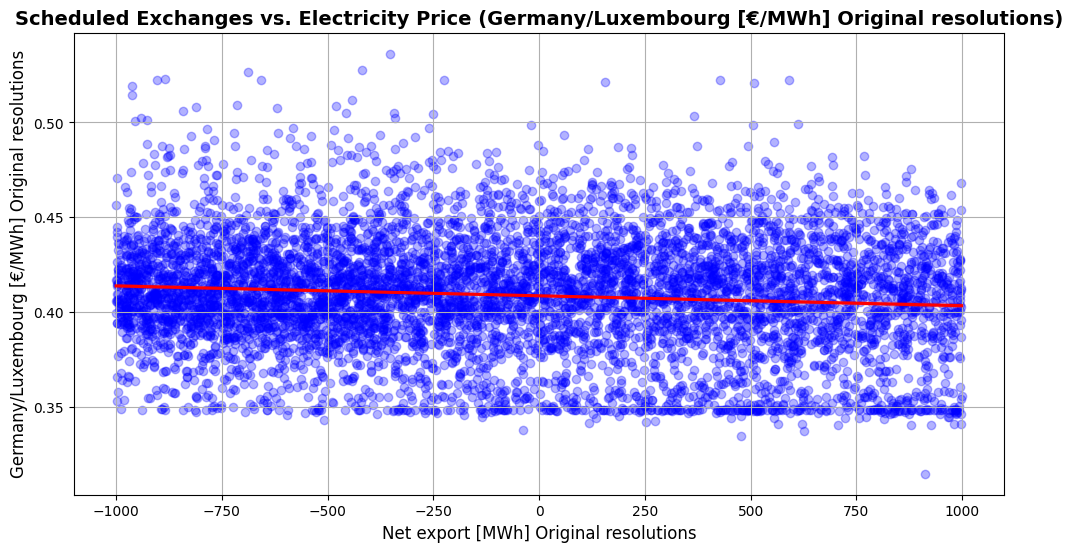

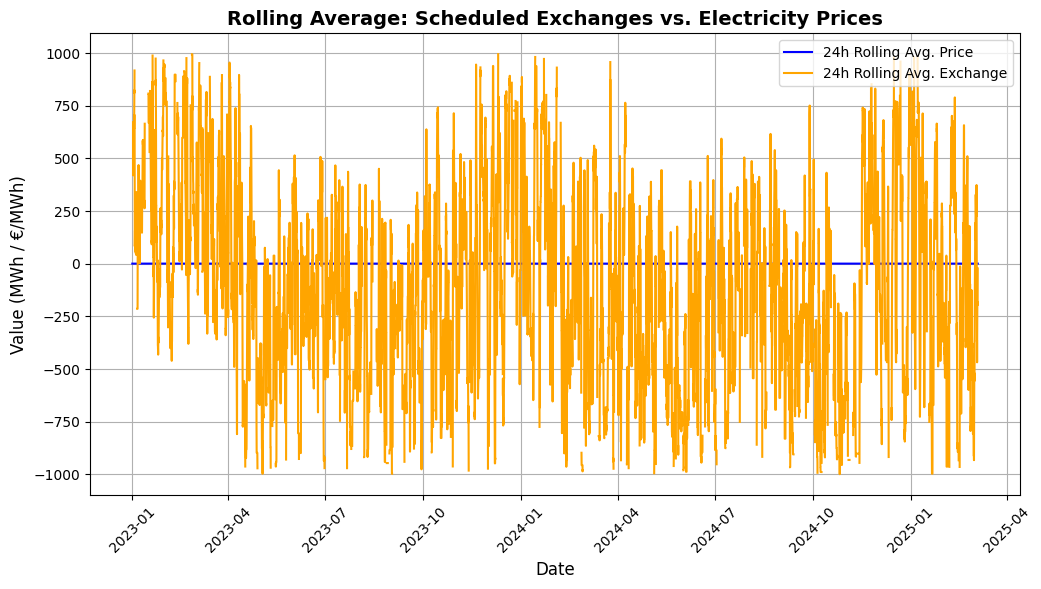

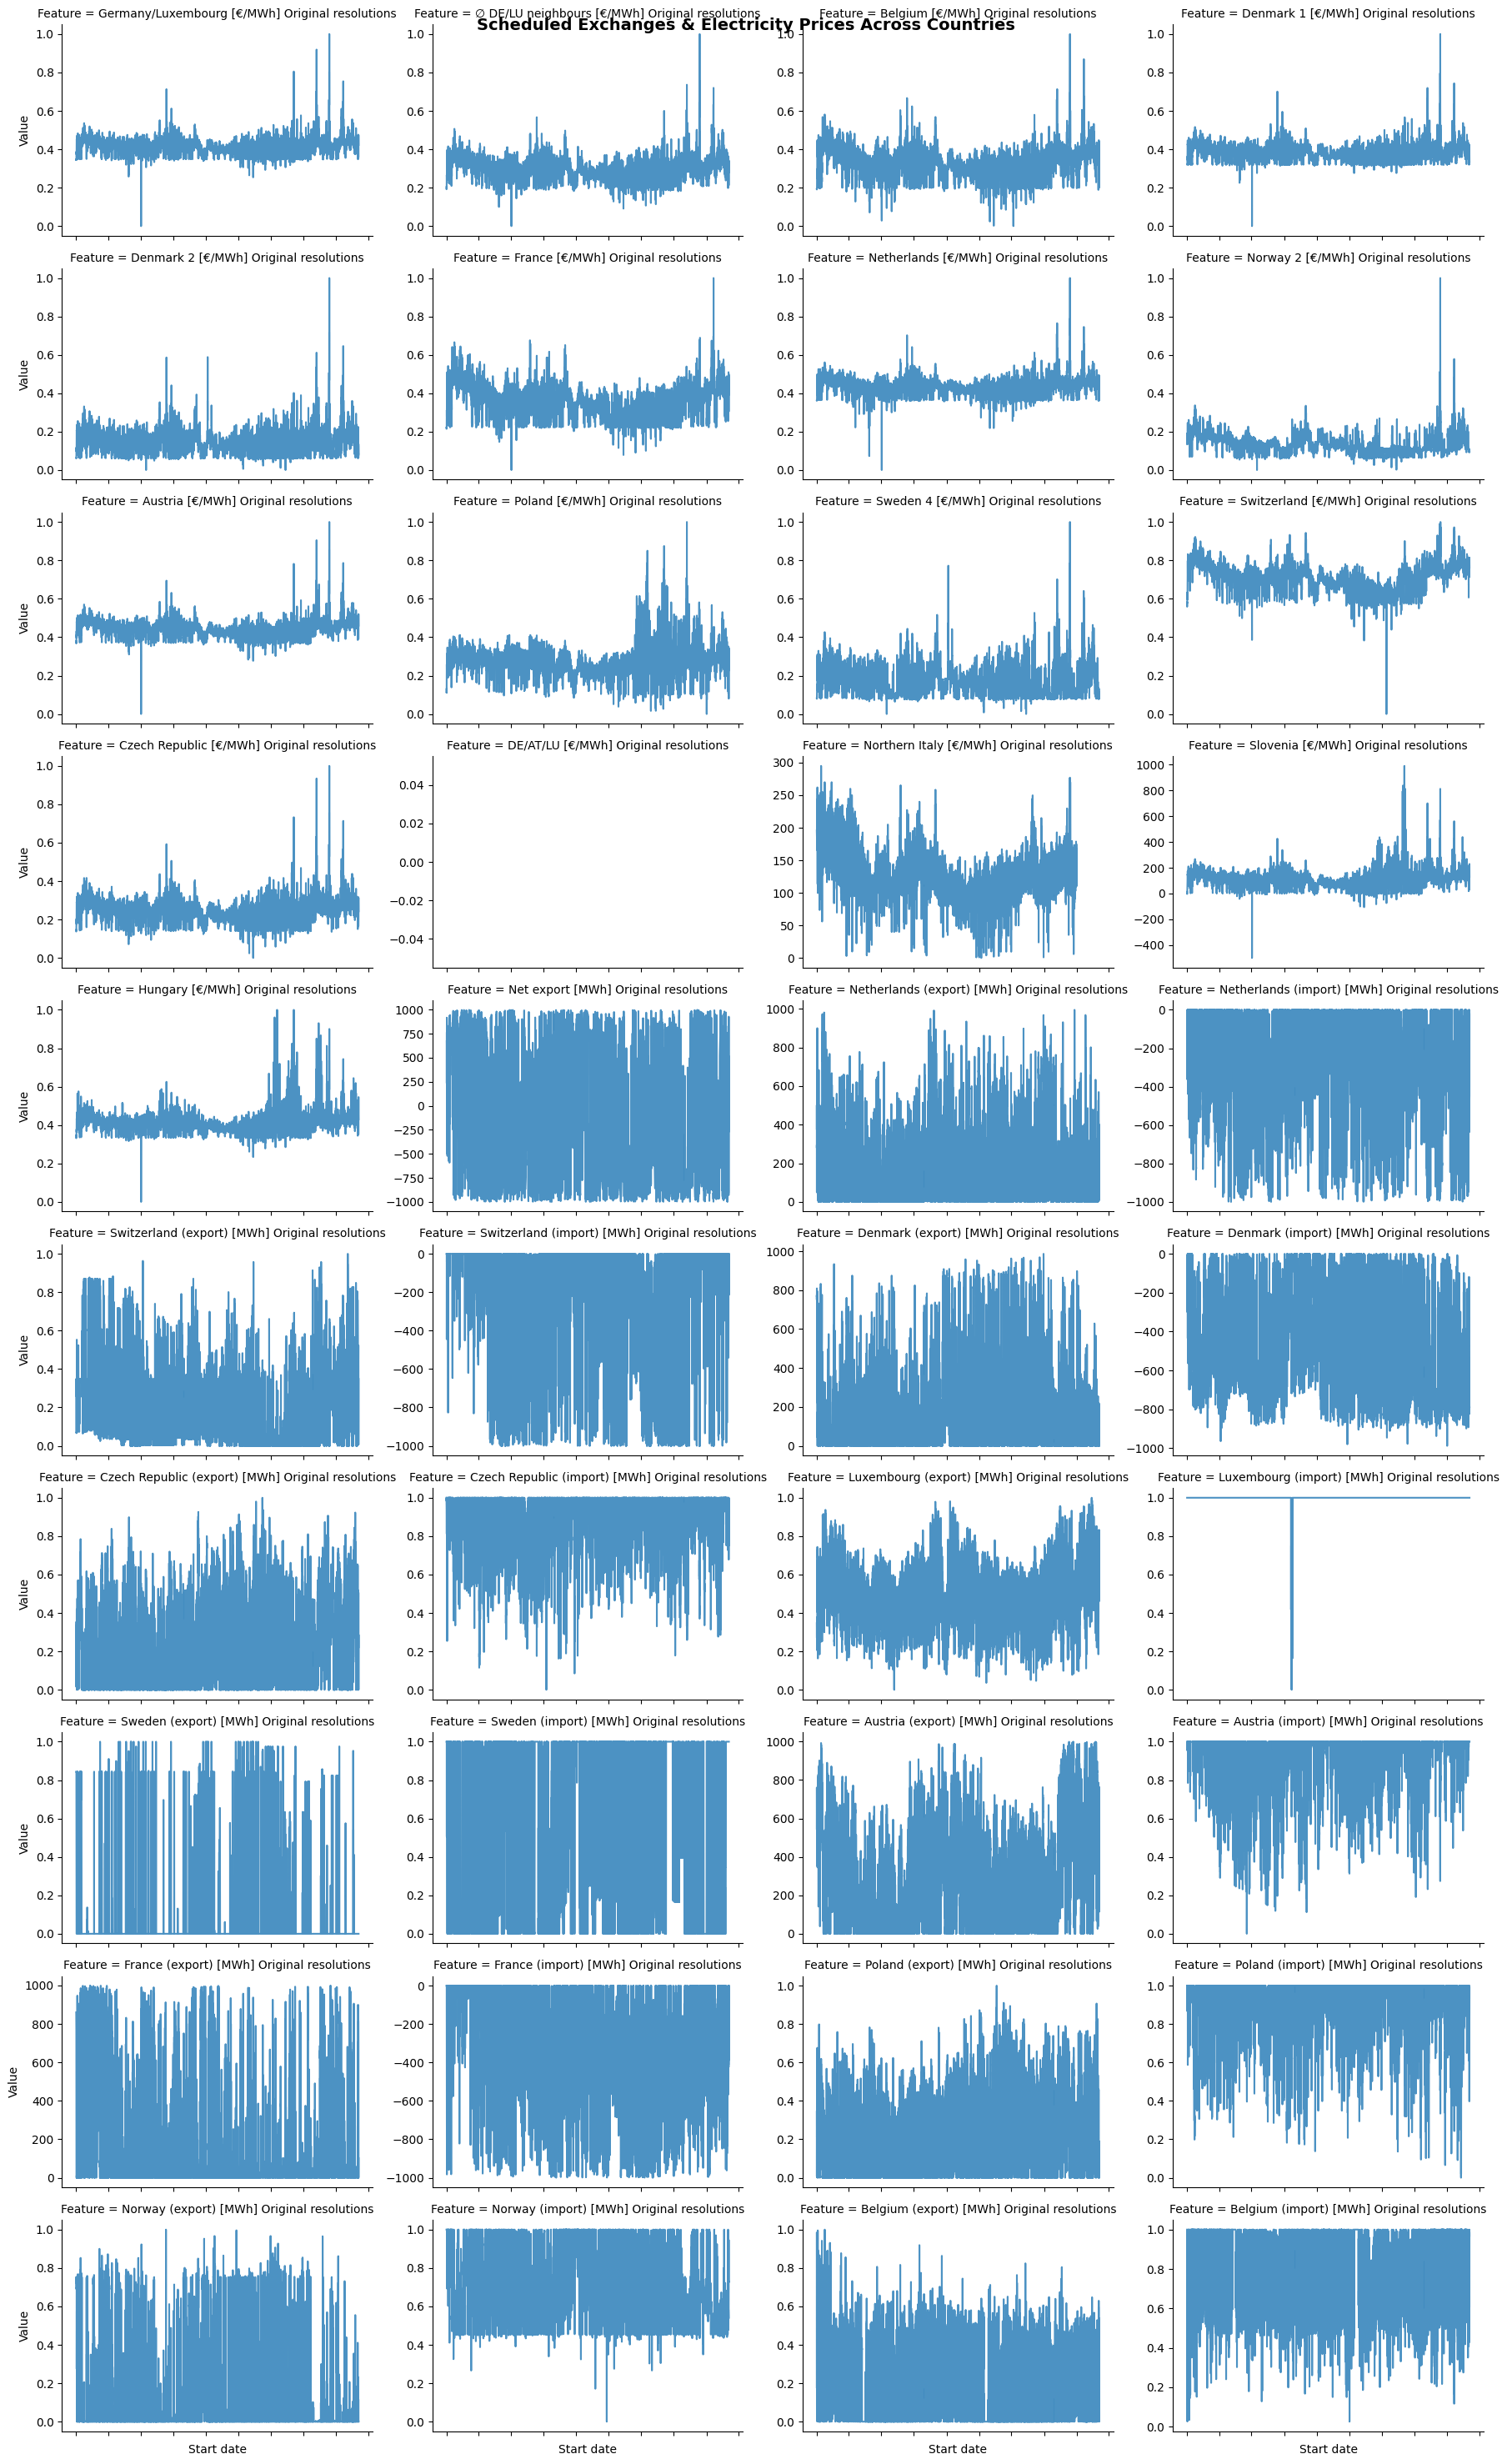

✅ Plots saved in '../plots' directory.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define paths
PLOTS_DIR = "../plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

# Load datasets
exchange_file = "../data/refined_files/refined_cleaned_Scheduled_commercial_exchanges_202301010000_202503050000_Quarterhour.csv"
price_file = "../data/refined_files/refined_cleaned_Day-ahead_prices_202301010000_202503050000_Hour.csv"

df_exchange = pd.read_csv(exchange_file, delimiter=",", low_memory=False)
df_price = pd.read_csv(price_file, delimiter=",", low_memory=False)

# Convert time column to datetime
df_exchange["Start date"] = pd.to_datetime(df_exchange["Start date"], errors="coerce")
df_price["Start date"] = pd.to_datetime(df_price["Start date"], errors="coerce")

# Merge datasets
df_merged = df_price.merge(df_exchange, on="Start date", how="inner")

# Select price and exchange columns
price_columns = [col for col in df_price.columns if "€/MWh" in col]
exchange_columns = [col for col in df_exchange.columns if "[MWh]" in col]

# Convert columns to numeric
df_merged[price_columns] = df_merged[price_columns].apply(pd.to_numeric, errors="coerce")
df_merged[exchange_columns] = df_merged[exchange_columns].apply(pd.to_numeric, errors="coerce")

# Select sample country for analysis
country_price = price_columns[0]  # Adjust as needed
exchange_flow = exchange_columns[0]  # Adjust as needed

# 📌 **1️⃣ Scatter Plot with Regression Line**
plt.figure(figsize=(12, 6))
sns.regplot(
    x=df_merged[exchange_flow], 
    y=df_merged[country_price], 
    scatter_kws={"alpha": 0.3, "color": "blue"}, 
    line_kws={"color": "red"}
)
plt.xlabel(exchange_flow, fontsize=12)
plt.ylabel(country_price, fontsize=12)
plt.title(f"Scheduled Exchanges vs. Electricity Price ({country_price})", fontsize=14, fontweight="bold")
plt.grid()
plt.savefig(os.path.join(PLOTS_DIR, "scatter_scheduled_exchanges_vs_price.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# 📌 **2️⃣ Rolling Average Trends (Time Series)**
df_merged["Rolling_Price"] = df_merged[country_price].rolling(window=24, min_periods=1).mean()
df_merged["Rolling_Exchange"] = df_merged[exchange_flow].rolling(window=24, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_merged["Start date"], df_merged["Rolling_Price"], label="24h Rolling Avg. Price", color="blue")
plt.plot(df_merged["Start date"], df_merged["Rolling_Exchange"], label="24h Rolling Avg. Exchange", color="orange")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value (MWh / €/MWh)", fontsize=12)
plt.title("Rolling Average: Scheduled Exchanges vs. Electricity Prices", fontsize=14, fontweight="bold")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.savefig(os.path.join(PLOTS_DIR, "trend_scheduled_exchanges_vs_price.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

# 📌 **3️⃣ Country-Wise Facet Grid**
melted_df = df_merged.melt(id_vars=["Start date"], value_vars=price_columns + exchange_columns, var_name="Feature", value_name="Value")

g = sns.FacetGrid(melted_df, col="Feature", col_wrap=4, sharex=True, sharey=False, height=3, aspect=1.5)
g.map_dataframe(sns.lineplot, x="Start date", y="Value", alpha=0.8)
g.set_xticklabels(rotation=45)
g.fig.suptitle("Scheduled Exchanges & Electricity Prices Across Countries", fontsize=14, fontweight="bold")
g.fig.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "facetgrid_scheduled_exchanges_vs_price.png"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

print("✅ Plots saved in '../plots' directory.")
